In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import re
year_pattern = r'([1-2][0-9]{3})'
import networkx as nx
import community as community_louvain
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! pip install pyvis

     |████████████████████████████████| 756 kB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import sys
import ast

import plotly.express as px

#import nltk
#from nltk.corpus import stopwords
#import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db

import sys
import os

sys.path.append("..")

from pathlib import Path

import json

from itertools import combinations
from collections import Counter
from itertools import chain
import random

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import multiprocessing
import smart_open

from gensim.models.word2vec import Word2Vec

from pyvis.network import Network

from IPython.core.display import display, HTML

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [5]:
def json2pd(file_path):
    with open(file_path) as f:
        temp_data = [json.loads(line) for line in f]
    df = pd.DataFrame(temp_data)
    return df

In [7]:
data = json2pd('/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json')
data.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [8]:
selected_categories = ['cs.CL', 'cs.AI']
filtered_df = data[data['categories'].isin(selected_categories)]
filtered_df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
1393,0704.1394,Tarik Had\v{z}i\'c,"Tarik Hadzic, Rune Moller Jensen, Henrik Reif ...",Calculating Valid Domains for BDD-Based Intera...,None,None,None,None,cs.AI,None,In these notes we formally describe the func...,"[{'version': 'v1', 'created': 'Wed, 11 Apr 200...",2007-05-23,"[[Hadzic, Tarik, ], [Jensen, Rune Moller, ], [..."
2009,0704.2010,Juliana Bernardes,"Juliana S Bernardes, Alberto Davila, Vitor San...",A study of structural properties on profiles HMMs,"6 pages, 7 figures",None,None,None,cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,Motivation: Profile hidden Markov Models (pH...,"[{'version': 'v1', 'created': 'Mon, 16 Apr 200...",2008-12-11,"[[Bernardes, Juliana S, ], [Davila, Alberto, ]..."
3432,0704.3433,Tshilidzi Marwala,Tshilidzi Marwala and Bodie Crossingham,Bayesian approach to rough set,"20 pages, 3 figures",None,None,None,cs.AI,None,This paper proposes an approach to training ...,"[{'version': 'v1', 'created': 'Wed, 25 Apr 200...",2007-05-23,"[[Marwala, Tshilidzi, ], [Crossingham, Bodie, ]]"
3514,0704.3515,Jegor Uglov Mr,"J. Uglov, V. Schetinin, C. Maple",Comparing Robustness of Pairwise and Multiclas...,None,None,10.1155/2008/468693,None,cs.AI,None,"Noise, corruptions and variations in face im...","[{'version': 'v1', 'created': 'Thu, 26 Apr 200...",2016-02-17,"[[Uglov, J., ], [Schetinin, V., ], [Maple, C., ]]"
3707,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",None,None,None,cs.CL,None,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[[Corominas-Murtra, Bernat, ]]"


In [9]:
selected_year = 2020
filtered_df2 = filtered_df.copy()
filtered_df2['year'] = filtered_df['versions'].apply(lambda x: x[-1].get('created').split(" ")[3])
filtered_df2 = filtered_df2[filtered_df2['year'] >= str(selected_year)]
filtered_df2.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,year
409297,1302.4957,David Heckerman,"David Heckerman, Dan Geiger",Learning Bayesian Networks: A Unification for ...,This version has improved pointers to the lite...,None,None,UAI-P-1995-PG-274-284,cs.AI,http://creativecommons.org/licenses/by/4.0/,We examine Bayesian methods for learning Bay...,"[{'version': 'v1', 'created': 'Wed, 20 Feb 201...",2021-07-01,"[[Heckerman, David, ], [Geiger, Dan, ]]",2021
420644,1304.1511,David Heckerman,David Heckerman,A Tractable Inference Algorithm for Diagnosing...,Appears in Proceedings of the Fifth Conference...,None,None,UAI-P-1989-PG-174-181,cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,We examine a probabilistic model for the dia...,"[{'version': 'v1', 'created': 'Wed, 27 Mar 201...",2022-12-07,"[[Heckerman, David, ]]",2022
421490,1304.2357,David Heckerman,David Heckerman,An Empirical Comparison of Three Inference Met...,Appears in Proceedings of the Fourth Conferenc...,None,None,UAI-P-1988-PG-158-169,cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,"In this paper, an empirical evaluation of th...","[{'version': 'v1', 'created': 'Wed, 27 Mar 201...",2023-01-26,"[[Heckerman, David, ]]",2023
504933,1403.0034,Manfred Eppe,Manfred Eppe,Tractable Epistemic Reasoning with Functional ...,There are flaws in the mathematical background...,None,None,None,cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,We present an epistemic action theory for tr...,"[{'version': 'v1', 'created': 'Sat, 1 Mar 2014...",2020-11-26,"[[Eppe, Manfred, ]]",2020
505975,1403.1076,Kieran Greer Dr,Kieran Greer,Is Intelligence Artificial?,This new version adds some clarity to the disc...,"Euroasia Summit, Congress on Scientific Resear...",None,None,cs.AI,http://arxiv.org/licenses/nonexclusive-distrib...,Our understanding of intelligence is directe...,"[{'version': 'v1', 'created': 'Wed, 5 Mar 2014...",2021-08-30,"[[Greer, Kieran, ]]",2021


In [10]:
filtered_df3 = filtered_df2[filtered_df2['title'].str.contains('chatgpt|large language model|language model|llm', case=False)|filtered_df2['abstract'].str.contains('chatgpt|large language model|language model|llm', case=False)]
selected_columns = ['id', 'title', 'categories', 'abstract', 'versions', 'doi', 'authors_parsed']
filtered_df4 = filtered_df3[selected_columns]
filtered_df4['authors'] = filtered_df4['authors_parsed'].apply(lambda authors: [(" ".join(author)).strip() for author in authors])
filtered_df4['author_pairs'] = filtered_df4['authors'].apply(lambda x:list(combinations(x, 2)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
data = filtered_df4.copy()

## For our Analysis, we will consider authors who have published papers after 2020 and published more than 2 papers.


In [12]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(15713, 2)

In [13]:
## Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'authors'].tolist()
len(nodes_to_keep)

2555

### Generating the Edges of the Co-Author Network

In [14]:
authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Al-Olimat Hussein S.', 'Thirunarayan Krishnaprasad', 1),
 ('Al-Olimat Hussein S.', 'Shalin Valerie', 1),
 ('Al-Olimat Hussein S.', 'Sheth Amit', 1),
 ('Thirunarayan Krishnaprasad', 'Shalin Valerie', 1),
 ('Thirunarayan Krishnaprasad', 'Sheth Amit', 1),
 ('Shalin Valerie', 'Sheth Amit', 1),
 ('Mielke Sabrina J.', 'Eisner Jason', 3),
 ('Lim Robert', 'Heafield Kenneth', 1),
 ('Lim Robert', 'Hoang Hieu', 1),
 ('Lim Robert', 'Briers Mark', 1)]

### Creating the Graph on the Complete Data

In [15]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

15603


### Filtering the Graph, to keep nodes (authors) who have atleast published 3 papers. We will also remove any isolated nodes in the generated network

In [16]:
## From the complete Graph, create a subgraph, with only the nodes to keep
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

2555


35

In [17]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)
del G1, sub_g

In [18]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  2520
Number of Edges in AUthor Graph  19103


## Implementing Deep Walk

**Deep walk uses the concept of Random Walks to assign an embedding to each node in the network.**

1. In Random Walk, given a node we pick one of its neighbours at random and move to this node and from this node again choose another node among its neighbours at random. This continues for a fixed number of steps.



2. Once we have random walks generated for every node in the network, in DeepWalk the next step is to predict probability of visiting node "v" on a random walk starting from node "u".

3. This is very similar to the Skip-Gram model used in Word2Vec Model in NLP, wherein we try to predict the neighbouring words given a particular target word.


### Define Function for Random Walk


In [19]:
def getRandomWalk(graph,node,length_of_random_walk):
    """ This function takes NetworkX Graph and a Node and generate random walk for a given length

    Returns the random walk (list of nodes traversed)

    Note: The same node may occcur more than once in a Random Walk.
    """
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        ## Choose a random neighbour of the current node

        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk

In [20]:
### For every Node in the Graph, get randomwalks . For eahc node, let us get random walks say around 10 times each of path length 10
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):

    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))

The data now is similar to list of words in a sentence and we can use gensim to create Node Embedding Model - here each author is a Node and Node is similar to word in a sentence

In [23]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,compute_loss=True)

In [ ]:
deepwalk_model.save("deepwalk_since2015.model")

## Lets Look who are similar authors

In [24]:
def getSimilarNodes(model,node):
    """
    This function takes deepwalk model and a node

    Returns the top 10 nodes (author) similar to the given node
    """
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes

In [28]:
getSimilarNodes(deepwalk_model,"Valerie Shalin")

KeyError: "word 'Valerie Shalin' not in vocabulary"

The top 3 similar authors have recently published a paper **Scaling Equilibrium Propagation to Deep ConvNets by Drastically Reducing its Gradient Estimator Bias**. They have published lot of work together in the recent years.

Jo Jason since 2019 has published 7 papers with Yoshua

### Let us look at the CoAuthorship Network of the top popular Authors

In [29]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,authors,Number of Papers Published
14789,Zhang Min,50
2013,Choi Yejin,49
10643,Schütze Hinrich,44
15073,Zhao Hai,43
13057,Wei Furu,43
...,...,...
6084,Kunz Jenny,1
6086,Kuo Hui-Chi,1
6087,Kuo Mu-Tien,1
6088,Kupari Hanna-Mari,1


Lets get the graph of these top  Authors with their first step neighbours.We consider the authors ranked 4th to 10th to help visualise the clusters better

In [36]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    '''
    This function takes a Graph and list of initial nodes

    Returns the set of immediate neighbours of these nodes

    '''
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)

        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

In [37]:
coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['authors'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

502
Number of CoAuthor Nodes  359


### Generate a Co-Author Graph from the complete Graph

In [38]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  3467


In [39]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

### Visualise the generated network

We can see some clusters already. Lets see if embeddings is able to seperate these clusters
### Cluster the Nodes - based on Embeddings

Idea is to see if similar nodes belong to the same cluster.

In [40]:
def getCosineDistanceMatrix(vectors):
    '''
    This function takes list of vectors or numpy array

    Returns the pairwise cosine similarity matrix
    '''
    if type(vectors)==list:
        X=np.asarray(vectors)
    elif type(vectors)==np.ndarray:
        X=vectors
    else:
        print("Error in Data Type . Need to Pass list or numpy array as input argument")
        return []
    cosine_dist=cosine_distances(X)
    return cosine_dist


coauthor_nodes=list(coauthor_subgraph.nodes)
print("Number of CoAuthor Subgraph Nodes",len(coauthor_nodes))

coauthor_embeddings=[deepwalk_model.wv[node] for node in coauthor_nodes]

coauthor_embeddings=np.asarray(coauthor_embeddings)

print(coauthor_embeddings.shape)

cosine_dist=getCosineDistanceMatrix(coauthor_embeddings)

Number of CoAuthor Subgraph Nodes 359
(359, 100)


### Apply K-Means tp select the optimal number of clusters


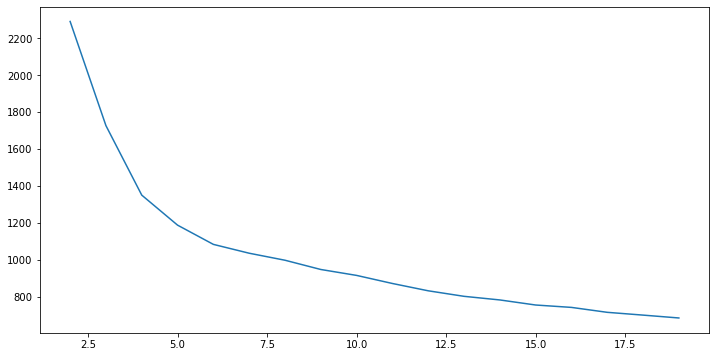

In [42]:
sse=[]
k_list=[]
for k in range(2,20):

    km=KMeans(n_clusters=k)
    km.fit(cosine_dist)
    sse.append(km.inertia_)


plt.figure(figsize=(12,6))
plt.plot([i for i in range(2,20)],sse)


Lets pick 7 clusters and update Node Attribute of the coAuthor Subgraph


In [43]:
km=KMeans(n_clusters=7)
coauthor_clusters=km.fit_predict(cosine_dist)
coauthor_cluster_dict={node:str(coauthor_clusters[idx]) for idx,node in enumerate(coauthor_nodes)}
nx.set_node_attributes(coauthor_subgraph,coauthor_cluster_dict,"group")

pyvis_nt=Network(notebook=True,height='600px', width='100%',heading='Author Network')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)
pyvis_nt.toggle_physics(True)
print("Saving PyVis Graph")
#pyvis_nt.show_buttons()
#pyvis_nt.set_options('var options = {"edges": { "color": { "inherit": true },"smooth": false},"physics": {"hierarchicalRepulsion": { "centralGravity": 0 },"minVelocity": 0.75, "solver": "hierarchicalRepulsion","timestep": 0.18}}')


pyvis_nt.show("Author4to10_CoAuthorGraph_Clustered.html")

Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph_Clustered.html


We can see that the embeddings has done a pretty good job at clustering the network.

### Visualising Bengio Yoshuas Network

In [ ]:
bengio_nodes=getCoAuthorshipNetwork(G,['Bengio Yoshua'])
bengio_network=nx.subgraph(G,bengio_nodes)
print("Number of Nodes in Bengio Network ",len(bengio_network.nodes()))
print("Number of Edges in Bengio Network ",len(bengio_network.edges()))

bengio_nt=Network(notebook=True,height='800px', width='100%',heading='Bengio Network')

print("Creating PyVis from NetworkX")
bengio_nt.from_nx(bengio_network)
bengio_nt.toggle_physics(True)
#bengio_nt.enable_physics(True)
print("Saving PyVis Graph")

bengio_nt.show_buttons()
bengio_nt.show("Bengio_CoAuthorGraph.html")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2426574 entries, 0 to 2426573
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 259.2+ MB


In [7]:
import pandas as pd

def get_overall_latest_date(df):
    """Finds the overall latest publication-related date from the DataFrame"""

    all_dates = []
    for row in df.itertuples():  # Iterate over each row in the DataFrame
        # Extract dates from the row's data
        for version in row.versions:
            all_dates.append(pd.to_datetime(version['created']))
        all_dates.append(pd.to_datetime(row.update_date))

    return max(all_dates).date()

# Your DataFrame (df) 
overall_latest_date = get_overall_latest_date(data)
print(f"Overall Latest Date: {overall_latest_date}") 

KeyboardInterrupt: 

In [5]:
cnt_llm = 0
cnt_chatgpt = 0
for i in range(len(data)):
    if "chatgpt" in data.title.iloc[i].lower():
        cnt_chatgpt+=1
    elif "language models" in data.title.iloc[i].lower():
        cnt_llm+=1
    elif "large language models" in data.title.iloc[i].lower():
        cnt_llm+=1

In [ ]:
print(cnt_llm, cnt_chatgpt)

In [7]:
filtered_df = data[data['title'].str.contains('chatgpt|large language model|language model', case=False)]

In [10]:
filtered_df.categories.value_counts()[:20]

cs.CL                  2185
cs.CL cs.AI            1129
cs.CL cs.LG             508
cs.CL cs.AI cs.LG       479
cs.CV                   230
cs.SE                   138
cs.AI                   129
cs.LG cs.CL             106
cs.LG cs.AI cs.CL        87
cs.AI cs.CL              80
cs.IR                    78
cs.LG                    71
cs.CV cs.AI              65
cs.CV cs.CL              61
cs.HC                    58
cs.CL cs.SD eess.AS      56
cs.CL cs.IR              50
cs.LG cs.AI              46
cs.IR cs.CL              45
cs.SE cs.AI              44
Name: categories, dtype: int64

In [ ]:
# Utility function 
# Function to parse author names
def parse_authors(authors):
    parsed_authors = []
    split_by_comma = authors.split(',')
    for author in split_by_comma:
        split_by_and = author.split(' and ')
        for final_author in split_by_and:
            cleaned_name = final_author.strip().replace('\n', ' ')
            parsed_authors.append(cleaned_name)
    return parsed_authors

In [ ]:
# https://arxiv.org/help/api/user-manual
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

In [5]:
# https://arxiv.org/help/api/user-manual
category_map = {'cs.AI': 'Artificial Intelligence',
'cs.CL': 'Computation and Language'}

In [6]:
df = data.copy()

In [ ]:
# Convert the "update_date" column to datetime format
df['update_date'] = pd.to_datetime(df['update_date'])

# Define the start and end of your time window
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2023-12-31')

# Filter rows where "update_date" is within the specified range
df = df[(df['update_date'] >= start_date) & (df['update_date'] <= end_date)]

# Display the filtered DataFrame
print(df)

In [8]:
filtered_df = df[df['categories'].isin(category_map.keys())]

In [ ]:
# Collaboration Network Analysis: This would involve creating a network where nodes represent authors and edges represent collaborations on papers. Such an analysis could 
# reveal patterns and communities within scientific collaboration, help identify key researchers in specific fields, and show how collaboration networks evolve over time.
# Initialize an empty graph
G = nx.Graph()

# Step 2: Network Construction
for i in range(len(filtered_df)):
    authors = filtered_df['authors_parsed'].iloc[i]
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author_i = " ".join(authors[i][:2])  # Combine first name and last name
            author_j = " ".join(authors[j][:2])  # Combine first name and last name
            if G.has_edge(author_i, author_j):
                # If the edge exists, increment the weight
                G[author_i][author_j]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(author_i, author_j, weight=1)

# Step 3: Visualization
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=10, edge_color='gray')
plt.title("Collaboration Network")
plt.axis('off')
plt.show()

# Step 4: Analysis
# Calculate and print some basic network statistics
print(f"Number of nodes (authors): {G.number_of_nodes()}")
print(f"Number of edges (collaborations): {G.number_of_edges()}")

# Degree Centrality
degree_centrality = nx.degree_centrality(G)
# Print the author(s) with the highest degree centrality
max_degree_centrality = max(degree_centrality.values())
central_authors = [author for author, centrality in degree_centrality.items() if centrality == max_degree_centrality]
print(f"Author(s) with the highest degree centrality: {central_authors}")

In [ ]:
# Community Detection on the full graph
partition = community_louvain.best_partition(G)
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()):
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20, node_color=str(count / size))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

# Temporal Analysis: Print basic stats for each year's graph
# By tracking publication dates and update dates, one could analyze trends over time, such as the growth of certain research areas, changes in collaboration patterns, or the 
# evolution of topics.

for year, graph in graphs_by_year.items():
    print(f"Year: {year}, Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")

# Note: For a more detailed temporal analysis, you could visualize or analyze each year's graph individually.

In [ ]:
# Keyword Co-occurrence Network Analysis: By analyzing the frequency of keywords within paper titles or abstracts, we can build a network where nodes are keywords and 
# edges represent their co-occurrence in the same papers. This can highlight the main topics being researched, show relationships between different areas of study, and 
# indicate emerging fields.

# Function to extract keywords using spaCy
def extract_keywords_spacy(text):
    doc = nlp(text)
    keywords = set()
    for token in doc:
        # Filter out punctuation, spaces, stop words, and select nouns and verbs
        if token.is_stop != True and token.is_punct != True and not token.tag_ == "SPACE" and (token.pos_ == "NOUN" or token.pos_ == "VERB"):
            keywords.add(token.lemma_)  # Use lemma for the base form of the word
    return keywords

# Initialize an empty graph
G = nx.Graph()

# Build the network
for paper in dataset:
    title_keywords = extract_keywords_spacy(paper['title'])
    abstract_keywords = extract_keywords_spacy(paper['abstract'])
    keywords = title_keywords.union(abstract_keywords)
    
    # Add nodes and edges for every combination of keywords in this paper
    for keyword_pair in itertools.combinations(keywords, 2):
        if G.has_edge(*keyword_pair):
            G[keyword_pair[0]][keyword_pair[1]]['weight'] += 1
        else:
            G.add_edge(keyword_pair[0], keyword_pair[1], weight=1)

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)  # Adjust this for larger networks
nx.draw_networkx(G, pos, node_size=20, edge_color="gray", alpha=0.4, with_labels=False)
nx.draw_networkx_labels(G, pos, font_size=7, font_color="black")
plt.title("Keyword Co-occurrence Network")
plt.axis('off')
plt.show()

# Basic Analysis
print(f"Number of nodes (keywords): {G.number_of_nodes()}")
print(f"Number of edges (co-occurrences): {G.number_of_edges()}")

### preparing data

In [ ]:
year_categories = {}
year_abstract_words = {}
year_authors = {}
metadata = get_metadata()
for ind, paper in tqdm(enumerate(metadata)):
    paper = json.loads(paper)
    
    # try to extract year
    if paper['journal-ref']:
        year = re.match(year_pattern, paper['journal-ref']).groups() if re.match(year_pattern, paper['journal-ref']) else None
        if year:
            year = [int(i) for i in year if int(i) < 2020 and int(i) >= 1991]
            if year == []:
                year = None
            else:
                year = min(year)
    else:
        year = None
                    
    if year:   
        if year not in year_categories.keys():
            year_categories[year] = defaultdict(int)
            year_abstract_words[year] = defaultdict(int)
            year_authors[year] = defaultdict(int)
    # collect counts of various things over years
    for cat in paper['categories']:
        for c in cat.split():
            if year:
                year_categories[year][c] += 1
    for word in paper['abstract'].replace('\n', ' ').split():
        if year:
            year_abstract_words[year][word] += 1
    paper_authors = authors.get(paper['id'])
    if paper_authors:
        if year:
            for author in paper_authors:
                year_authors[year][' '.join(author)] += 1

## Number of papers by categories over years

I'll take top 10 most popular categories from each year and plot all of them.

**A warning beforehand**! There is no field with data of the paper, so I extracted it from `journal-ref` with regex. There could be some errors in regex, also some papers don't have `journal-ref`.

In [ ]:
df = pd.DataFrame(year_categories)
cats = []
for col in df.columns:
    top_cats = [i for i in df[col].fillna(0).sort_values().index][-10:]
    cats.extend(top_cats)
cats = list(set(cats))

df1 = df.T[cats]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['index'])
df2.columns = ['year', 'category', 'count']
fig = px.line(df2, x="year", y="count", color='category')
fig.show()

In [ ]:
for c in sorted(cats):
    if c in category_map:
        print(f"{c}: {category_map[c]}")

There are so many different and interesting trends!
* for example, there are some fluctuations due to terminology - at first there were a lot of papers in `astro-ph` category, but later it was split in multiple categories
* there was a surge in papers on astrophysics since 2010, but since 2014 `Cosmology and Nongalactic Astrophysics` became less popular than `Astrophysics of Galaxies`
* of course, in the last several years there are many papers about `Machine Learning`

## Number of papers by authors over years

In [ ]:
df = pd.DataFrame(year_authors)
authors = []
for col in df.columns:
    top_authors = [i for i in df[col].fillna(0).sort_values().index][-10:]
    authors.extend(top_authors)
authors = list(set(authors))

df1 = df.T[authors]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['index'])
df2.columns = ['year', 'author', 'count']
fig = px.line(df2, x="year", y="count", color='author', width=1600, height=600)
fig.show()

We can see some prominent authors from many fields on study!